<a href="https://colab.research.google.com/github/urmzd/school/blob/main/year-four/CSCI4155/assignments/a2/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Assignment 2


## Part 1: Synthetic dataset


**Question 1** Start by generating a 2D dataset that has 3 Gaussian clusters. The first two should be as in the cluster creation exercise from class, i.e., cluster 1 should be centred at (10,10) and be spherical and cluster 2 should be centred at (0,0) and have contours in the shape of an ellipse (with a radius ratio of roughly 4:1), while the third cluster can be whatever you'd like as long as it is distinct from the first two but still has some overlap with one of them. Include a 1000 datapoints for each cluster.


In [56]:
import numpy as np
import matplotlib.pyplot as plt

cluster_1 = np.random.normal((10, 10), (1, 1), (1000, 1, 2))
cluster_2 = np.random.normal((0, 0), (4, 1), (1000, 1, 2))
cluster_3 = np.random.normal((5, 5), (1.25, 2), (1000, 1, 2))
all_clusters = np.vstack([cluster_1, cluster_2, cluster_3])
print(all_clusters.shape)


(3000, 1, 2)


**Question 2** Produce a scatter plot of your clusters, assigning each cluster a different color.


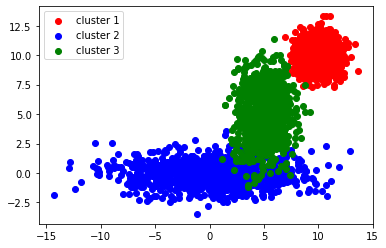

In [62]:
fig, ax = plt.subplots()
ax.scatter(cluster_1[..., 0], cluster_1[..., 1], label="cluster 1", c="red")
ax.scatter(cluster_2[..., 0], cluster_2[..., 1], label="cluster 2", c="blue")
ax.scatter(cluster_3[..., 0], cluster_3[..., 1], label="cluster 3", c="green")
ax.legend()


## Part 2: Clustering


Suppose you didn't know to which cluster each datapoint belonged to, and wanted to find out. One of the first things you might try is the following algorithm, where $k$ is a hyperparameters controlling the number of clusters we're trying to find:

1. Initialize the k cluster centroids, $\mu_1, \mu_2, \ldots, \mu_k$, randomly.
2. Repeat until convergence **(Question 1: what should the convergence criterion be?)**:
   1. Assign each datapoint to the cluster with the nearest centroid;
   2. Re-calculate the cluster centroids, i.e. the mean of all datapoints assigned to each cluster


## Question 1 Answer

Various criterias can be used when determine when the algorithm has converged.

The most straightforward and simple approach would be to stop when the algorithm has iterated atleast $X$ times.

Another approach would involve variance tracking. Every iteration, we would measure the variance found in each cluster and stop when one, sone or all of the cluster's variance has not improved by a given threshold value $\tau$.

Alternatively, clustering can stop when the previous and current clusters centroids have not changed or have only changed by a given threshold distance $\phi$.


**Question 2**: Implement this in Python. Define a Python class $\it{clustering}$, that takes as initialization parameters $\it{n_{clusters}}$, the number of clusters, $\it{n_{iter}}$, the maximum number of iterations of the above algorithm, and any other parameters you feel are needed to check for convergence (if any). The cluster centroids should be a class attribute. Define two methods, $\it{fit}$, taking in a set of points, $\mathbf{X}$ and performing clustering using the algorithm above, and $\it{predict}$, that takes in a set of points and returns a prediction for which cluster those points belong to.


In [58]:
from dataclasses import dataclass, field


def get_distance(p, q):
    """Returns the Euclidean distance between `p` and `q`."""
    return np.sum(np.power((p - q), 2), axis=-1)


def get_k_centroids(k=3, lb=-20.0, ub=20.0) -> np.ndarray:
    """Returns K centroids somewhere in the range (lb,ub] in the shape (k, 2)"""
    return np.random.uniform(lb, ub, (k, 2))


# print(get_distance(get_k_centroids(), all_clusters))


@dataclass
class NaiveKClustering:
    n_clusters: int = 3
    n_iters: int = 50
    centroids: np.ndarray = field(default_factory=get_k_centroids)
    min_distance_update_threshold: float = 1e-20

    def fit(self, X: np.ndarray) -> None:
        prev_centroids = self.centroids
        for _ in range(self.n_iters):

            pred_clusters, distances = self.predict(
                X, centroids=prev_centroids, return_distances=True
            )
            clusters = [[] for _ in range(prev_centroids.shape[0])]

            # Group all points by their predicted cluster.
            for point_idx, cluster_idx in enumerate(pred_clusters):
                clusters[cluster_idx].append(X[point_idx])

            # Stop if the centroids have failed to update significantly.
            new_centroids = np.array(
                [
                    np.average(np.vstack(cluster), axis=0)
                    if len(cluster) > 0
                    else np.zeros(2,)
                    for cluster in(clusters)
                ]
            )

            # print(new_centroids)
            prev_centroids = new_centroids

        self.centroids = prev_centroids
        # print("ALL ITERATIONS USED!")

    def predict(self, X, centroids=None, return_distances=False) -> np.ndarray:
        centroids_to_use = self.centroids if centroids is None else centroids
        # Calculate the distance between the points and centroids.
        distances = get_distance(centroids_to_use, X)

        # A point is associated to the closest centroid.
        pred_clusters = np.argmin(distances, axis=-1)

        if return_distances:
            return pred_clusters, distances

        return pred_clusters


**Question 3**: Use your clustering class on the synthetic dataset you created in Part 1. Comment on how well it clusters your dataset.


INITIAL_CENTROIDS: [[ 11.19673807  -8.386025  ]
 [-14.89071201  16.54811382]
 [  8.23460746  17.60057812]]
FINAL_CENTROIDS: [[ 5.01754484  3.80747913]
 [-1.70260694 -0.13185971]
 [ 9.83516987  9.92134895]]




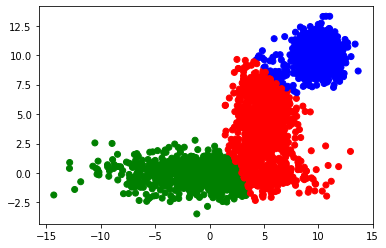

In [72]:
@dataclass
class RunData:
    final_centroids: np.ndarray
    inital_centroids: np.ndarray
    cluster_1: np.ndarray 
    cluster_2: np.ndarray 
    cluster_3: np.ndarray 

def map_array_to_colours(X, colours=["red", "green", "blue"]):
  return np.array(list(map(lambda index: colours[index], X)))

def run_instance() -> RunData:
  model = NaiveKClustering()
  intial_centroids = model.centroids
  model.fit(all_clusters)
  cluster_1_preds = model.predict(cluster_1)
  cluster_2_preds = model.predict(cluster_2)
  cluster_3_preds = model.predict(cluster_3)

  run_data = RunData(
    final_centroids= model.centroids,
    inital_centroids= intial_centroids,
    cluster_1 = cluster_1_preds,
    cluster_2 = cluster_2_preds,
    cluster_3 = cluster_3_preds
  )

  return run_data 

def plot_run_instance(instance: RunData):
  _, ax = plt.subplots()
  print(f"INITIAL_CENTROIDS: {instance.inital_centroids}")
  ax.scatter(cluster_1[..., 0], cluster_1[..., 1], c=map_array_to_colours(instance.cluster_1))
  ax.scatter(cluster_2[..., 0], cluster_2[..., 1], c=map_array_to_colours(instance.cluster_2))
  ax.scatter(cluster_3[..., 0], cluster_3[..., 1], c=map_array_to_colours(instance.cluster_3))
  print(f"FINAL_CENTROIDS: {instance.final_centroids}")
  print("\n")
  
plot_run_instance(run_instance())

### Conclusion

The model is able to cluster the points relatively well. 
There's some confusion in areas where intersection between the clusters is predomindant. However, the true clusters and the predicted clusters resemble in shape, hence demonstrating that the clustering algorithm performed well.

**Question 4**: How do the found clusters vary as you run the algorithm again?


INITIAL_CENTROIDS: [[ 7.65763689 -8.91123372]
 [ 7.12205082 -2.35684425]
 [ 6.38285933 17.80295533]]
FINAL_CENTROIDS: [[-1.70260694 -0.13185971]
 [ 5.01754484  3.80747913]
 [ 9.83516987  9.92134895]]


INITIAL_CENTROIDS: [[ -5.2558508   12.50292545]
 [  5.86226035  16.31451069]
 [-12.83526366   1.00442933]]
FINAL_CENTROIDS: [[ 5.01754484  3.80747913]
 [ 9.83516987  9.92134895]
 [-1.70260694 -0.13185971]]


INITIAL_CENTROIDS: [[  8.04010716 -17.87944497]
 [ 12.51640172 -11.33028496]
 [  1.81705619  14.64328279]]
FINAL_CENTROIDS: [[-1.70260694 -0.13185971]
 [ 5.01754484  3.80747913]
 [ 9.83516987  9.92134895]]


INITIAL_CENTROIDS: [[-6.27315544 12.7155513 ]
 [ 4.9493578  13.77475136]
 [12.92131103 -5.08752866]]
FINAL_CENTROIDS: [[-1.70260694 -0.13185971]
 [ 9.83516987  9.92134895]
 [ 5.01754484  3.80747913]]


INITIAL_CENTROIDS: [[-16.246907    -2.61821101]
 [  8.69898035   9.81346217]
 [-12.75983805 -15.06978092]]
FINAL_CENTROIDS: [[-1.70260694 -0.13185971]
 [ 9.83516987  9.92134895]
 [

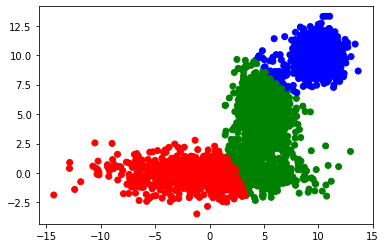

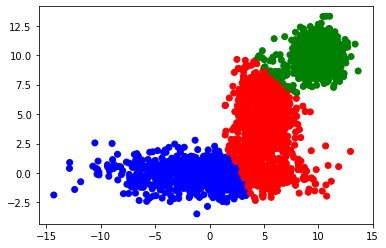

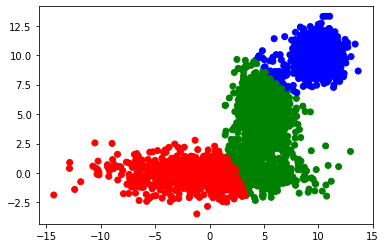

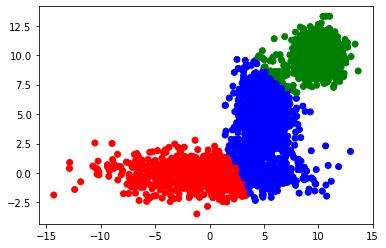

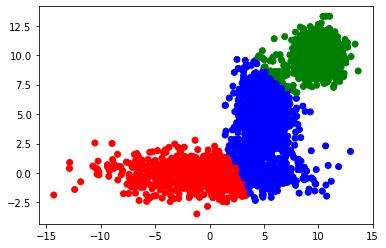

In [70]:
for _ in range(5):
  instance = run_instance()
  plot_run_instance(instance)

### Conclusion

There are no signifcant changes on the shape of the clusters when re-running the algorithm.